In [11]:
# Importing all necessary libraries
# ipython magic functions for automatic reloading code changes in .py files
%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter, OrderedDict
# external packages
import torch
import torchvision
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline



# specify base model name
model_name = "autoencoder.pth"


print("Versions")
print("torch: ",torch.__version__)
print("torchvision: ",torchvision.__version__)
print("numpy: ", np.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Versions
torch:  1.6.0
torchvision:  0.7.0
numpy:  1.18.1


In [12]:
# some utility functions, you can skip those in the beginning
def denormalize(tensor:torch.Tensor, mean:float=0.0653, std:float=0.2285):
    """This applies an inverse z-transformation and reshaping to visualize the cmnist images properly.
    """
    pt_std = torch.as_tensor(std, dtype=torch.float32, device=tensor.device)
    pt_mean = torch.as_tensor(mean, dtype=torch.float32, device=tensor.device)
    return (tensor.mul(pt_std).add(pt_mean).view(-1, 1, 56,56) * 255).int().detach()

def plot_images(images:torch.Tensor, pad:int=1):
    """Aligns multiple images on an N by 8 grid"""
    def imshow(img):
        plt.figure(figsize=(10, 20))
        npimg = img.numpy()
        npimg = np.array(npimg)
        plt.axis('off')
        plt.imshow(np.transpose(npimg, (1, 2, 0)),
                   vmin=0, vmax=1)
    
    imshow(torchvision.utils.make_grid(images, pad_value=255, normalize=False, padding=pad))
    plt.show();
    
def detect_device():
    """Automatically detects if you have a cuda enabled GPU"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    return device

def encode_batchwise(dataloader, model, device):
    """ Utility function for embedding the whole data set in a mini-batch fashion
    """
    embeddings = []
    for batch in dataloader:
        batch_data = batch[0].to(device)
        embeddings.append(model.encode(batch_data).detach().cpu())
    return torch.cat(embeddings, dim=0).numpy()

def decode_batchwise(dataloader, model, device):
    """ Utility function for decoding the whole data set in a mini-batch fashion
    """
    decodings = []
    for batch in dataloader:
        batch_data = batch[0].to(device)
        decodings.append(model(batch_data).detach().cpu())
    return torch.cat(decodings, dim=0).numpy()

In [13]:
class Autoencoder(torch.nn.Module):
    """A vanilla symmetric autoencoder.
    
    Args:
        input_dim: size of each input sample
        embedding_size: size of the inner most layer also called embedding

    Attributes:
        encoder: encoder part of the autoencoder, responsible for embedding data points
        decoder: decoder part of the autoencoder, responsible for reconstructing data points from the embedding    
    """
    def __init__(self, input_dim:int, embedding_size:int):
        super(Autoencoder, self).__init__()
        
        # make a sequential list of all operations you want to apply for encoding a data point
        self.encoder = torch.nn.Sequential(
            # Linear layer (just a matrix multiplication)
            torch.nn.Linear(input_dim, 256),
            # apply an elementwise non-linear function
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(256, 128),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(128, 64),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(64, embedding_size))
        
        # make a sequential list of all operations you want to apply for decoding a data point
        # In our case this is a symmetric version of the encoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(embedding_size, 64),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(64, 128),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(128, 256),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(256, input_dim),
            )
    
    def encode(self, x:torch.Tensor)->torch.Tensor:
        """
        Args:
            x: input data point, can also be a mini-batch of points
        
        Returns:
            embedded: the embedded data point with dimensionality embedding_size
        """
        return self.encoder(x)
    
    def decode(self, embedded:torch.Tensor)->torch.Tensor:
        """
        Args:
            embedded: embedded data point, can also be a mini-batch of embedded points
        
        Returns:
            reconstruction: returns the reconstruction of a data point
        """
        return self.decoder(embedded)
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        """ Applies both encode and decode function. 
        The forward function is automatically called if we call self(x).
        Args:
            x: input data point, can also be a mini-batch of embedded points
        
        Returns:
            reconstruction: returns the reconstruction of a data point
        """
        embedded = self.encode(x)
        reconstruction = self.decode(embedded)
        return reconstruction

model = Autoencoder(input_dim=56*56, embedding_size=10)
print(model)


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=256, out_features=3136, bias=True)
  )
)


In [14]:
import torch.utils.data
import torchvision.transforms as transforms
from torchvision import datasets

def preprocess_data_and_extract_labels(dl, class_dict):
    """ Applies preprocessing to the CMNIST data and extracts the class labels. 
        Args:
            dl: dataloader, calls torch.vision.transforms on all minibatches 
            class_dict: dictionary of all ground truth clusterings
        
        Returns:
            pt_data: concatenated data set as torch.tensor, 
            pt_labels: concatenated labels as torch.tensor
    """
    pt_data = []
    pt_labels = []
    for batch in dl:
        img, label = batch
        pt_data.append(img)
        for label_i in label.tolist():
            cl = class_dict[label_i].split("_")
            cl = torch.tensor([int(cl[0]), int(cl[1])])
            pt_labels.append(cl)
    pt_data = torch.cat(pt_data, dim=0)
    pt_labels = torch.stack(pt_labels)
    return pt_data, pt_labels


def load_cmnist():
    """ Loads and preprocesses the CMNIST data set. 
        Make sure you extract the directory in the same place as this notebook.
        
        Returns:
            pt_data: concatenated data set as torch.tensor, 
            pt_labels: concatenated labels as torch.tensor
    """
    std = (0.2285,)
    mean = (0.0653,)
    def to_grey(x):
        return x.convert('L')
    transform = transforms.Compose([to_grey,
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std),
                                    ])
    # Assumed data directory name is cmnist_reduced
    dataset = datasets.ImageFolder(root='cmnist_reduced', transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
    classes = dataset.classes
    class_dict = {i: c_i for i, c_i in enumerate(classes)}
    pt_data, pt_labels = preprocess_data_and_extract_labels(dataloader, class_dict=class_dict)
    return pt_data.reshape(-1, 56*56), pt_labels

In [15]:
data, labels = load_cmnist()
print("Number of data points: ", data.shape[0])
print("Number of dimensions: ", data.shape[1])

Number of data points:  5811
Number of dimensions:  3136


In [ ]:
data, labels = load_cmnist()
print("Data Set Information")
print("Number of data points: ", data.shape[0])
print("Number of dimensions: ", data.shape[1])
print(f"Mean: {data.mean():.4f}, Standard deviation: {data.std():.4f}")
print(f"Min: {data.min():.2f}, Max: {data.max():.2f}")
print("Number of classes 0: ", len(set(labels[:,0].tolist())))
print("Number of classes 1: ", len(set(labels[:,1].tolist())))

print("Class 0 distribution:\n", sorted(Counter(labels[:,0].tolist()).items()))
print("Class 1 distribution:\n", sorted(Counter(labels[:,1].tolist()).items()))

Data Set Information
Number of data points:  5811
Number of dimensions:  3136


In [6]:
# Optional: Uncomment and run if you want to only use a subsample of CMNIST due to runtime constraints

# subsample_size=2000
# rng = np.random.default_rng()
# idx = rng.choice(data.shape[0], size=subsample_size, replace=False)
# data = data[idx]
# labels = labels[idx]
# print("Data Set Information")
# print("Number of data points: ", data.shape[0])
# print("Number of dimensions: ", data.shape[1])
# print(f"Mean: {data.mean():.2f}, Standard deviation: {data.std():.2f}")
# print(f"Min: {data.min():.2f}, Max: {data.max():.2f}")
# print("Number of classes 0: ", len(set(labels[:,0].tolist())))
# print("Number of classes 1: ", len(set(labels[:,1].tolist())))

# print("Class 0 distribution:\n", sorted(Counter(labels[:,0].tolist()).items()))
# print("Class 1 distribution:\n", sorted(Counter(labels[:,1].tolist()).items()))

Plot some images to see if everything worked:


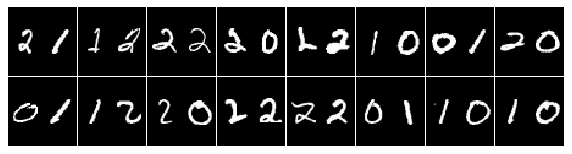

Plot some reconstructed images with the randomly initialized autoencoder


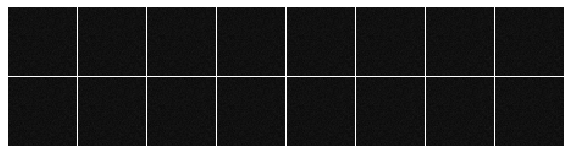

In [17]:
to_plot = 16
print("Plot some images to see if everything worked:")
plot_images(denormalize(data[0:to_plot]))
print("Plot some reconstructed images with the randomly initialized autoencoder")
reconstruction = model(data[0:to_plot].to(device)).detach().cpu()
plot_images(denormalize(reconstruction))

In [16]:
# Set all parameters needed for training

# The size of the mini-batch that is passed in each trainings iteration
batch_size = 128
# The learning rate specifies the step size of the gradient descent algorithm
learning_rate = 1e-3
# Maximum training epochs
epochs = 50
# Set device on which the model should be trained on (For most of you this will be the CPU)
device = detect_device()
print("Use device: ", device)

# load model to device (cpu or gpu)
model.to(device)

# create a Dataloader to train the autoencoder in mini-batch fashion
trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(*(data, labels)),
                                          batch_size=batch_size,
                                          # sample random mini-batches from the data
                                          shuffle=True,
                                          drop_last=False)

# create a Dataloader to evaluate the autoencoder in mini-batch fashion (Important for validation)
evalloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(*(data, labels)),
                                         batch_size=batch_size,
                                         # Note that we deactivate the shuffling, this means data points 
                                         # will be in the same order as the input data
                                         shuffle=False,
                                         drop_last=False)

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# define loss function
loss_fn = torch.nn.MSELoss()

# path to were we want to save/load the model to/from
pretrained_model_path = "pretrained_" + model_name

Use device:  cpu


In [18]:
def fit(model, loss_fn, trainloader, optimizer, epochs, device):
    train_loss = []
    # TODO: Implement the training loop
    for epoche1 in range(epochs):
        running_loss = 0.0
        for data in trainloader:
            img,_ = data
            img = img.to(device)
            optimizer.zero_grad()
            outputs = model(img)
            loss = loss_fn(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoche1+1, epochs, loss))
        
        #if epoche1 % 5 == 0:
            #save_image(img, 'pretrained_model_path'.format(epoch))
            #save_decod_img(outputs.cpu().data, epoche1)
    return train_loss
   

# Train the autoencoder
#fit(model, loss_fn, trainloader, optimizer, epochs, device)

In [9]:
train_loss = fit(model, loss_fn, trainloader, optimizer, epochs, device)

Epoch 1 of 50, Train Loss: 0.704
Epoch 2 of 50, Train Loss: 0.535
Epoch 3 of 50, Train Loss: 0.461
Epoch 4 of 50, Train Loss: 0.433
Epoch 5 of 50, Train Loss: 0.391
Epoch 6 of 50, Train Loss: 0.353
Epoch 7 of 50, Train Loss: 0.330
Epoch 8 of 50, Train Loss: 0.313
Epoch 9 of 50, Train Loss: 0.302
Epoch 10 of 50, Train Loss: 0.292
Epoch 11 of 50, Train Loss: 0.284
Epoch 12 of 50, Train Loss: 0.276
Epoch 13 of 50, Train Loss: 0.271
Epoch 14 of 50, Train Loss: 0.266
Epoch 15 of 50, Train Loss: 0.263
Epoch 16 of 50, Train Loss: 0.259
Epoch 17 of 50, Train Loss: 0.256
Epoch 18 of 50, Train Loss: 0.253
Epoch 19 of 50, Train Loss: 0.251
Epoch 20 of 50, Train Loss: 0.247
Epoch 21 of 50, Train Loss: 0.244
Epoch 22 of 50, Train Loss: 0.242
Epoch 23 of 50, Train Loss: 0.240
Epoch 24 of 50, Train Loss: 0.238
Epoch 25 of 50, Train Loss: 0.236
Epoch 26 of 50, Train Loss: 0.234
Epoch 27 of 50, Train Loss: 0.233
Epoch 28 of 50, Train Loss: 0.231
Epoch 29 of 50, Train Loss: 0.229
Epoch 30 of 50, Train L

In [10]:
# save model for later processing        
torch.save(model.state_dict(), pretrained_model_path)


In [11]:
# load model from disk
state_dict = torch.load(pretrained_model_path, map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

Original Images


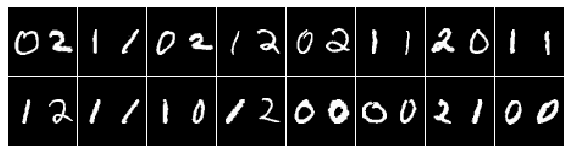

Reconstructed Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


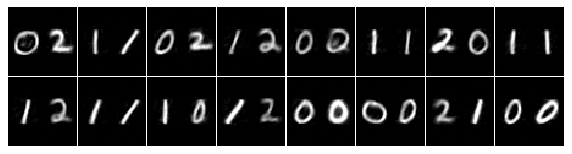

In [12]:
# Plot the reconstructed images to see how well the trained model performs at reconstructing the data:
to_plot = 16
print("Original Images")
plot_images(denormalize(data[0:to_plot]))
print("Reconstructed Images")
reconstruction = model(data[0:to_plot].to(device)).detach().cpu()
plot_images(denormalize(reconstruction))

In [13]:
# Final reconstruction loss. You should reach an MSE of around 0.17 with the above setting
recs = decode_batchwise(evalloader, model, device)
loss_fn(torch.from_numpy(recs), data)

tensor(0.2054)